In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target

c:\Users\William Costa\Documents\repositories\hands_on_machine_learning\.venv\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X.shape, y.shape

((70000, 784), (70000,))

'5'

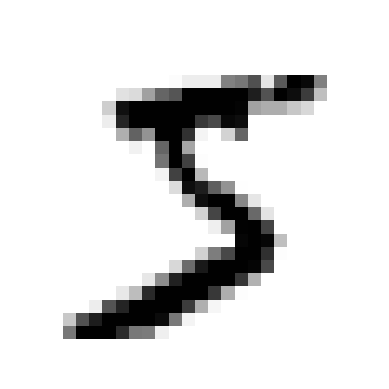

In [4]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

plot_digit(X[0])
y[0]

In [5]:
# We don't do any split strategies because this dataset already contains this division
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

## Training a Binary Classifier

In [6]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier()
sgd_classifier.fit(X_train, y_train_5)
sgd_classifier.predict([X_test[0]]), y_test_5[0]

(array([False]), False)

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [8]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96375, 0.9663 , 0.9421 ])

In [9]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train, y_train_5)
any(dummy_classifier.predict(X_train)), cross_val_score(dummy_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

(False, array([0.90965, 0.90965, 0.90965]))

**NOTE:** Since data is skewed (only 10% is 5) we have a baseline of 90% accuracy just by saying that it is not a 5

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_predict = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_predict)
cm, y_train_predict.shape

(array([[53311,  1268],
        [ 1040,  4381]], dtype=int64),
 (60000,))

In [11]:
import numpy as np
precision = cm[0, 0] / np.sum(cm[:, 0])
recall = cm[0, 0] / np.sum(cm[0])
precision, recall

(0.9808651174771393, 0.9767676212462669)

In [12]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_predict), recall_score(y_train_5, y_train_predict)

(0.7755354930076119, 0.8081534772182254)

In [13]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_predict)

0.7915085817524841

### The Precision/Recall Trade-off

It is very difficult to increase both precision and recall. After a certain threshold increasing one means decreasing the other one.
Our task is then to identify the main goal of our algorithm:
- We increase precision in cases where it is more important to decrease False Positives. (Ex: When filtering videos for children we need to make sure no inapropriate video gets through even if some appropriate videos don't get through);
- We increase recall in cases where is it more important to decrease False Negatives. (Ex: When detecting cancer it is better to diagnose someone has having cancer when he doesn't have it then saying a person is healthy when they have cancer)
- In cases where we want to decrease both scenarios we can use the f1-scrore which tries to find the place where the precision and recall are at their highest before the tradeoff begins.

Conclusion:
- Maximizing Precision -> precision=100% recall=50%
- Maximizing Recall -> precision=75% recall=100%
- Maximmizing F1-score -> precision=80% recall=67%

In [14]:
y_scores = sgd_classifier.decision_function([X_train[0]])
y_scores


y_scores, (y_scores > 0), (y_scores > 3000) # Example of increasing recall while decreasing precision

(array([2887.08621328]), array([ True]), array([False]))

In [15]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method='decision_function')

In [16]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

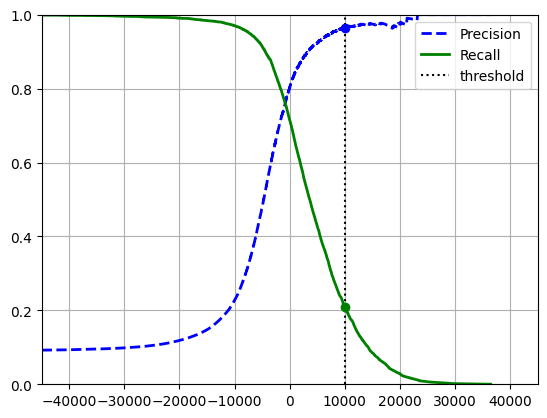

In [17]:
threshold = 10000
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label='threshold')
plt.grid(True)
plt.legend()
plt.xlim(-45_000, 45_000)
plt.ylim(0, 1.0)

idx = (thresholds >= threshold).argmax() # The highest value in an boolean array is True. The argmax finds the first occurence of the highest value.
plt.plot(thresholds[idx], precisions[idx], 'bo')
plt.plot(thresholds[idx], recalls[idx], 'go')

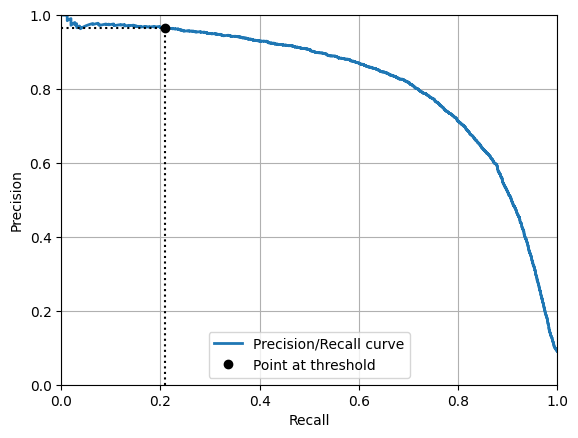

In [18]:
plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall curve')
plt.plot()
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.axis([0, 1, 0, 1])
plt.grid()

plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], 'k:')
plt.plot([recalls[idx], recalls[idx]], [0, precisions[idx]], 'k:')
plt.plot(recalls[idx], precisions[idx], 'ko', label='Point at threshold')

plt.legend()

In [19]:
# If you want to adjust threshold for 90% precision
idx_for_90_precision = (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3375.5250601979137

In [20]:
# You can now use the following for prediction
y_train_predict_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_5, y_train_predict_90), recall_score(y_train_5, y_train_predict_90) 

(0.9, 0.5113447703375761)

### ROC Curve

Used for binary classification. Plots recall against False Positive Rate (1 - True Negative Rate)

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

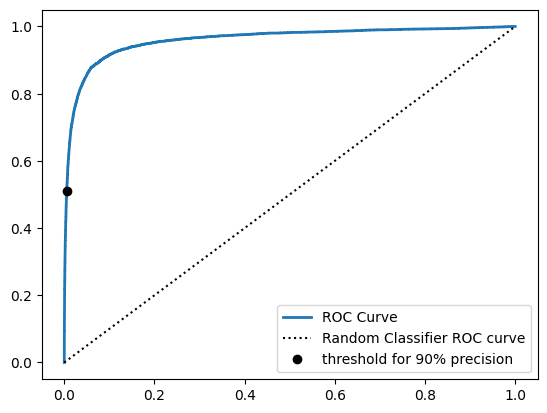

In [22]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label='ROC Curve')
plt.plot([0,1], [0,1], 'k:', label='Random Classifier ROC curve')
plt.plot([fpr_90], [tpr_90], 'ko', label='threshold for 90% precision')
plt.legend()

In [23]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9605913263545834

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(random_state=42)

y_probability_a_forest = cross_val_predict(forest_classifier, X_train, y_train_5, cv=3, method='predict_proba')
y_probability_a_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [25]:
y_scores_forest = y_probability_a_forest[:, 1]

precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

Text(0.5, 0, 'Recall')

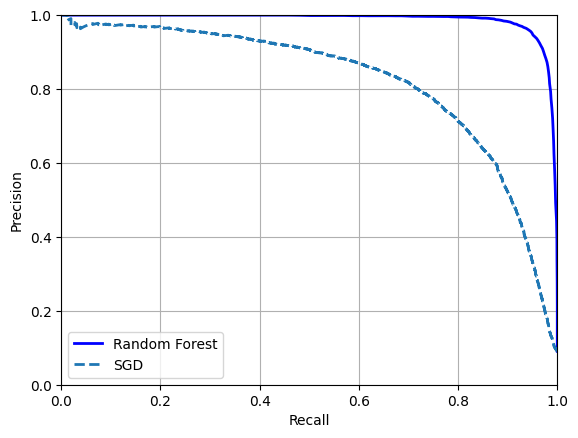

In [26]:
plt.plot(recalls_forest, precisions_forest, 'b-', linewidth=2, label='Random Forest')
plt.plot(recalls, precisions, '--', linewidth=2, label='SGD')
plt.axis([0,1,0,1])
plt.grid()
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Recall')

In [27]:
y_train_pred_forest = y_probability_a_forest[:, 1] >= 0.5
f1_score(y_train_5, y_train_pred_forest), roc_auc_score(y_train_5, y_scores_forest) 

(0.9274509803921569, 0.9983436731328145)

## Multiclass Classification

Some algorithms can only be used for binary classification. One way to overcome this problem is to have several binary classifiers, one for each class, and select the class with the highest value from the n binary classifiers. (OvR - One-versus-the-rest). We can also use One-versus-One where we have on binary classifier to compete between two different classes.

Ex. you have to distinguish between 1,2 and, 3 so you do the following:
- OvR -> Create three binary classifiers, (is1, is2, is3);
- OvO -> Create three binary classifiers (1or2, 1or3, 2or3).

- **OvR:** When there are a lot of classes this classifier suffers from skewedness. Here we train one classifier per class
- **OvO:** It only takes into account the two classes that are competing so it does not suffer from skewed dataset. It's main disadvantage is that we need to train several classifiers when we have several classes N x (N-1) / 2

In [28]:
from sklearn.svm import SVC

svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train[:2_000], y_train[:2_000])

SVC(random_state=42)

In [30]:
svm_classifier.predict([X_train[0]])

array(['5'], dtype=object)

In [32]:
# Shows one classifier per class
svm_classifier.decision_function([X_train[0]]).round(2), y_train[0]

(array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
          4.82]]),
 '5')

In [33]:
svm_classifier.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

**NOTE:** Depending on the classifier SKLearn chooses OvO or OvR. We can change this behaviour with the code below

In [34]:
from sklearn.multiclass import OneVsRestClassifier

ovr_classifier = OneVsRestClassifier(SVC(random_state=42))
ovr_classifier.fit(X_train[:2_000], y_train[:2_000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [35]:
ovr_classifier.predict([X_train[0]]), y_train[0]

(array(['5'], dtype='<U1'), '5')

In [36]:
ovr_classifier.decision_function([X_train[0]]).round(2)

(array([[-1.33, -1.79, -1.39, -0.94, -2.29,  0.81, -1.72, -1.21, -1.64,
         -1.79]]),
 '5')

In [42]:
from sklearn.multiclass import OneVsOneClassifier

ovo_classifier = OneVsOneClassifier(SVC(random_state=42))
ovo_classifier.fit(X_train[:2_000], y_train[:2_000])

ovo_classifier.predict([X_train[0]]), y_train[0]

(array(['5'], dtype=object), '5')

In [43]:
ovo_classifier.decision_function([X_train[0]]).round(2)

array([[ 3.79,  0.73,  6.05,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.2 ,
         4.82]])

## Error Analysis

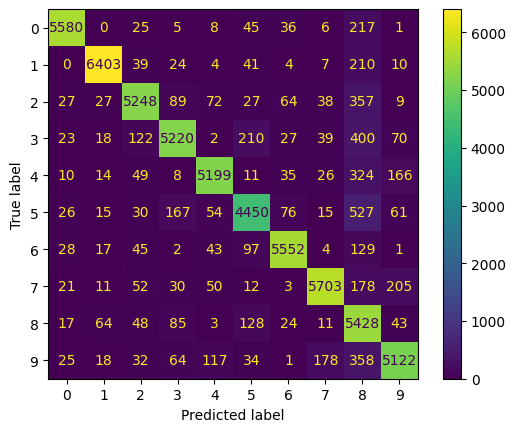

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))
y_train_predict = cross_val_predict(sgd_classifier, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict)

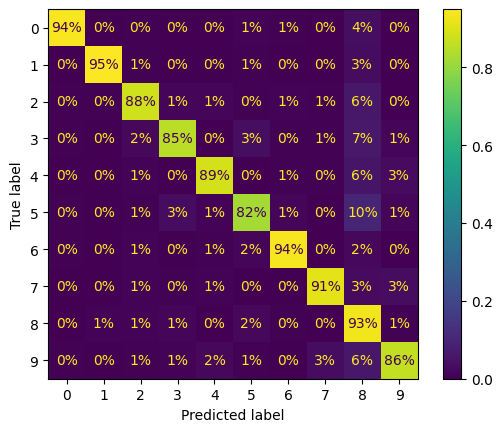

In [49]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict, normalize='true', values_format='.0%')

**NOTE:** We can notice on the Confusion matrix above that most nubers are confused as 8. To view this more accurately we can use a mask/weight to force the diagonal to 0 and study this assumption in more detail

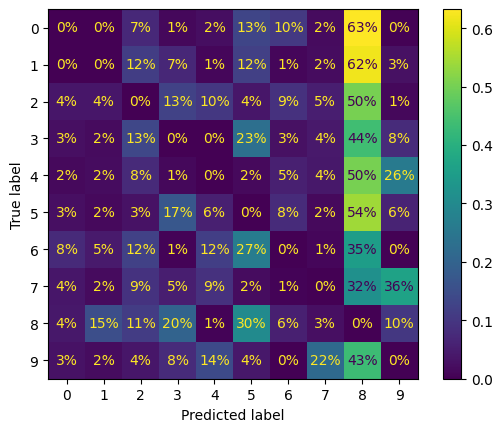

In [47]:
sample_weight = (y_train_predict != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict, sample_weight=sample_weight, normalize='true', values_format='.0%')
plt.title('Errors normalized by row')

**NOTE:** Our prediction was accurate. There is a high change, when we incorrectly classify a sample, to say it is an 8

Text(0.5, 1.0, 'Errors normalized by column')

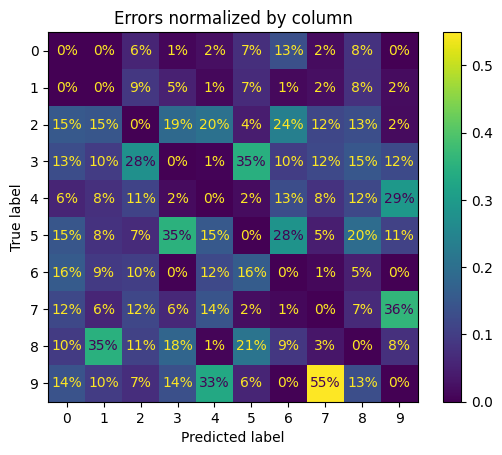

In [50]:
sample_weight = (y_train_predict != y_train)
ConfusionMatrixDisplay.from_predictions(
    y_train, y_train_predict, sample_weight=sample_weight, normalize='pred', values_format='.0%')
plt.title('Errors normalized by column')

**NOTE:** The difference between the last two graphs is the following:
- On the first graph we analyse by row. Ex: In True label 0 we can observe we confused 0 with 2 6% of the time;
- On the second graph we analyse by row. Ex: In Predicted label 7 we can observe of all the confusions made with 7 12% were for True Label 3.

From the analysis done so far we can see the classifier has trouble distinguishing between 8 and other numbers and between 7-9.
To fix this we can:
- Increase training set to include digits that look like 8 but aren't (3, 5, etc)
- Engineer a feature (Ex: number of closed loops)
- Change Preprocessing to make patterns more visible (Ex: change 5 to have sharper lines, make closed loops stand out)

In [51]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train==cl_a) & (y_train_predict == cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_predict == cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_predict == cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_predict == cl_b)]

Text(0, 0.5, 'True label')

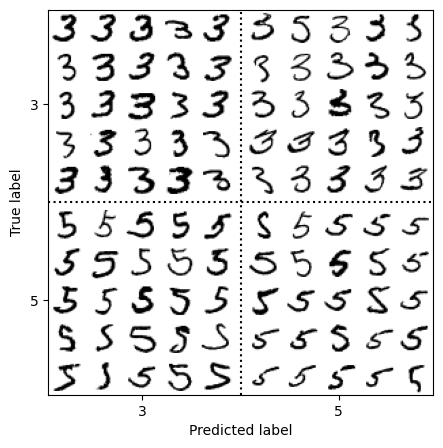

In [53]:
# extra code – this cell generates and saves Figure 3–11
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")

## Multilabel Classification

In [55]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [57]:
knn_classifier.predict([X_train[0]]), y_train[0]

(array([[False,  True]]), '5')

In [58]:
y_train_knn_prediction = cross_val_predict(knn_classifier, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_prediction, average='macro')

0.976410265560605

In [59]:
y_train_knn_prediction = cross_val_predict(
    knn_classifier, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_prediction, average='weighted')


0.9778357403921755

Since multilabel classification can have correlations between labels we can use a chain classifier. This classifier use the first prediction to help with the second.
Ex:
- Large (7,8,9) includes two odd numbers and 1 even number
- So if number is large there is a 66% chance it is odd
- So we use prediction from large as one of the inputs for isOdd

In [61]:
from sklearn.multioutput import ClassifierChain

chain_classifier = ClassifierChain(SVC(), cv=3, random_state=42)
chain_classifier.fit(X_train[:2_000], y_multilabel[:2_000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [62]:
chain_classifier.predict([X_train[0]])

array([[0., 1.]])

## Multioutput Classification

Multilabel Classifier where every class is a multiclass

Ex: Split an image in two -> Two image array outputs

In [65]:
image_size=784
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), image_size))
x_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), image_size))
x_test_mod = X_test + noise

In [66]:
y_train_mod = X_train
y_test_mod = X_test

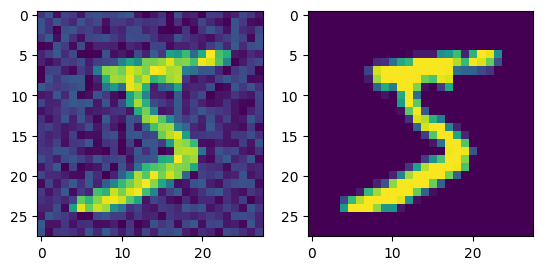

In [74]:
figure, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(x_train_mod[0].reshape(28,28))
ax1.imshow(y_train_mod[0].reshape(28,28))

In [77]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(x_train_mod, y_train_mod)

KNeighborsClassifier()

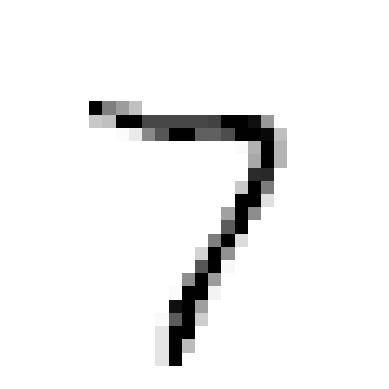

In [78]:
plot_digit(knn_classifier.predict([x_test_mod[0]]))